In [88]:
!pip install "deeplake<4"
!pip install --upgrade transformers
!pip install nltk
!pip install torchvision

In [89]:
import torch
import torch.nn as nn

import deeplake
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import transforms
from transformers import BertTokenizer, BertModel
import nltk
import random

from torch.utils.data import Dataset
from PIL import Image

## Preprocess Data

In [90]:
ds = deeplake.load('hub://activeloop/flickr30k')

\

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/flickr30k



|

hub://activeloop/flickr30k loaded successfully.



In [91]:
images = ds.image
captions = ds.caption_0 ## NextSteps: currently only training on caption0, could include other set of captions

### Tokenizing

In [92]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [93]:
## ALL Hyperparameters
caption_max_length = 20
vocab_size = len(tokenizer)

In [94]:
def process_image(image):
  """
  Image transformation functions
  Resizes images to 224x224, converts to tensor, and normalizes
  The normalization parameters are mean, SD of of r, g, b pixel values
  """
  image_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  image = image.numpy()
  image = Image.fromarray(image)
  image = image_transform(image)
  return image


def process_caption(caption_text):
  """
  Tokenizes captions
  Returns tensor of tokenized captions, with a max length of 20,
  padding until this length, and truncating if the caption is longer
  The individual entries in the tensor are integers
  """

  tokenized = tokenizer(caption_text,
                        max_length=caption_max_length,
                        padding='max_length',
                        truncation=True,
                        return_tensors='pt')

  input_ids = tokenized['input_ids']
  attention_mask = tokenized['attention_mask']
  return input_ids

def untokenize(tokenized_text):
    """
    Untokenizes a tensor
    Takes a tensor of integers, and according to tokenizer, returns
    original words
    """
    return tokenizer.decode(tokenized_text, skip_special_tokens=True)


#### Tests

tests for tokenizer

In [95]:
strings = ["hello world", "my dog went to the store", "the earth revolves around the sun",
           "I travelled to new york city and ate mexican and japanese food"]

def test_tokenizer(strings):
    """
    Function to test tokenizer, by tokenizing and untokenizing a string
    """
    for string in strings:
        # print ("input string: " + string)
        check = untokenize(process_caption(string)[0])
        # print ("output string: " + check)
        assert check.lower() == string.lower()
    print("All tests passed!")
test_tokenizer(strings)

All tests passed!


In [96]:
tokenizer.tokenize("Hello I am Wendy")
tokenizer.encode("Hello I am Wendy", add_special_tokens = True)

[101, 7592, 1045, 2572, 12815, 102]

### tests for data processing

In [97]:
def test_process_image():
  test_img = ds.image[0]
  transformed_img = process_image(test_img)
  assert transformed_img.size(1) == 224 and transformed_img.size(2) == 224, "Image resizing failed."
  assert transformed_img.size(0) == 3, "Image channel mismatch."
  print("All tests passed!")

test_process_image()


All tests passed!


In [98]:
def test_process_caption():
  caption = "A dog playing in the park."
  input_ids = process_caption(caption)
  assert input_ids.size(1) == 20, "Tokenized length incorrect."

  decoded_caption = untokenize(input_ids[0])
  assert decoded_caption.lower() == caption.lower(), "Caption untokenization incorrect."
  print("All tests passed!")
test_process_caption()

All tests passed!


### Dataset/Dataloader Creation

In [99]:
class Flickr30kDataset(Dataset):
    def __init__(self, images, captions, image_transform=None, caption_transform = None):
      """
      Initializes dataset
      """
      self.images = images
      self.captions = captions
      self.image_transform = image_transform
      self.caption_transform = caption_transform

    def __len__(self):
      """
      Returns length of the dataset
      """
      return len(self.captions)

    def __getitem__(self, idx):
      """
      Returns a single item (image, and caption processed according to
      caption_transform) from the dataset
      """
      image = self.images[idx]
      image = self.image_transform(image)

      caption = self.captions[idx].numpy()[0]
      caption_embedding = self.caption_transform(caption)
      return image, caption_embedding


In [100]:
from torch.utils.data import DataLoader, random_split

flickr_dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)

# 80% train, 10% val, 10% Test
train_size = int(0.8 * len(flickr_dataset))
val_size = int(0.1 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_dataset, eval_dataset, test_dataset = random_split(flickr_dataset, [train_size, val_size, test_size])

batch_size = 32 # TODO
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [155]:
## SMALLER DATASET FOR SAMPLE
from torch.utils.data import Subset
import random

# TODO:
train_n = 1000
eval_n = 2
batch = 1

train_indices = random.sample(range(len(flickr_dataset)), train_n)
train_subset = Subset(flickr_dataset, train_indices)
mini_train_dataloader = DataLoader(train_subset, batch_size=batch, shuffle=False)

eval_indices = random.sample(range(len(flickr_dataset)), eval_n)
eval_subset = Subset(flickr_dataset, eval_indices)
mini_eval_dataloader = DataLoader(eval_subset, batch_size=batch, shuffle=False)

#### Tests

tests for dataset

In [156]:
def test_flickr30k_dataset():
    dataset = Flickr30kDataset(images, captions, image_transform=process_image, caption_transform=process_caption)
    assert len(dataset) == len(captions), "Dataset length mismatch."

    image, caption_embedding = dataset[0]
    assert image.size(0) == 3 and image.size(1) == 224 and image.size(2) == 224, "Image shape incorrect."
    assert caption_embedding.size(1) == 20, "Caption max length incorrect."
    print("All tests passed!")

test_flickr30k_dataset()

All tests passed!


## CNN

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    """
    Initializes convolutional neural network
    """
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)

    self.relu = nn.ReLU()
    self.fc = nn.Linear(in_features=288, out_features=1024)
    self.fc2 = nn.Linear(1024, 256)
    self.flatten = nn.Flatten()

    self.maxPool = nn.MaxPool2d((2, 2), stride=2)

    self.batchNorm1 = nn.BatchNorm2d(4)
    self.batchNorm2 = nn.BatchNorm2d(16)
    self.batchNorm3 = nn.BatchNorm2d(32)

  def forward(self, x):
    """
    Forward pass of convolutional neural network
    """
    # for each layer, run convolutional layer, batch normalization layer,
    # then maxPool layer
    layer1 = self.maxPool(self.relu(self.batchNorm1(self.conv1(x))))
    layer2 = self.maxPool(self.relu(self.batchNorm2(self.conv2(layer1))))
    layer3 = self.maxPool(self.relu(self.batchNorm3(self.conv3(layer2))))
    x1 = self.flatten(layer3)
    # print(x1.shape) # 1, 288
    hidden = self.relu(self.fc(x1)) #1, 1024
    x = self.fc2(hidden) # 1, 4
    # print(x.shape )
    return x


#### Tests

Tests for CNN

In [ ]:
def test_cnn_forward_pass():
    cnn_model = CNN().to("cpu")
    test_img = torch.randn(1, 3, 224, 224).to("cpu")
    features = cnn_model(test_img)
    assert features.size(1) == 256, "CNN dimension incorrect."

test_cnn_forward_pass()

## RNN

In [ ]:
print("vocab size", tokenizer.vocab_size)
print("embed dim", bert_model.config.hidden_size)


vocab size 30522
embed dim 768


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size = 30522, embed_dim = 768, feature_dim = 256, hidden_dim= 512, max_length= 20):
      """
      Initializes RNN
      vocab_size = vocab size of bert tokenizer
      embed_dim = bert_model config hidden size
      feature_dim = from CNN output
      hidden_dim = hidden dimension of RNN
      """

      super(DecoderRNN, self).__init__()
      # embedding layer
      self.embedding = nn.Embedding(vocab_size, embed_dim)
      # long-short term memory nodes
      self.lstm = nn.LSTM(embed_dim + feature_dim, hidden_dim, batch_first=True)
      self.fc = nn.Linear(hidden_dim, vocab_size)
      self.max_length = max_length
      self.hidden_dim = hidden_dim

    def init_hidden(self, batch_size):
      """
      initialize hidden layer of model
      """
      return (torch.zeros(1, batch_size, self.hidden_dim).to(device), # h
              torch.zeros(1, batch_size, self.hidden_dim).to(device)) # c

    def forward(self, features, captions, hidden = None):
      """
      Runs one step of RNN
      """
      # Note: Initial caption is the <START> token
      embeddings = self.embedding(captions)  # (batch_size, max_length, embed_dim)
      features = torch.unsqueeze(features, 1) # (batch, 1, feature )
      inputs = torch.cat((features, embeddings), dim=2)  # (batch_size, max_length, embed_dim + feature_dim)

      lstm_out, hidden = self.lstm(inputs, hidden)  # (batch_size, max_length, hidden_dim)
      outputs = self.fc(lstm_out)  # (batch_size, max_length, vocab_size)
      return outputs, hidden


## TRAIN




In [ ]:
def train_model(cnn, rnn, data_loader, ratio = 0.5, device="cpu"):
  cnn.train()
  rnn.train()
  for epoch in range(num_epochs):
    total_loss = 0.0
    for images, captions in data_loader:
      images = images.to(device)
      captions = captions.to(device).long()

      batch_size = len(images) # for each item images set how many are there
      hidden = rnn.init_hidden(batch_size)

      optimizer_cnn.zero_grad()
      optimizer_rnn.zero_grad()

      features = cnn(images)
      captions = captions.squeeze(1)

      # Get the <Start> token
      decoder_input = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

      outputs = []

      # Teacher-forcing alg
      if random.random() < ratio:
        use_force = True
      else:
        use_force = True

      # Note RNN predicts one step ahead - cuz of the <start> token
      seq_length = captions.size(1)
      for t in range(1, seq_length):

          output, hidden = rnn(features, decoder_input, hidden)
          outputs.append(output)

          if use_force:
              decoder_input = captions[:, t].unsqueeze(1) # use true caption
          else:
              decoder_input = output.argmax(dim=2)

      outputs = torch.cat(outputs, dim=1)  # (batch , seq length - 1, vocab_size) 2, 19, vocabsize
      outputs = outputs.reshape(-1, outputs.size(2))  # batch * (seqlength - 1), vocab_size

      caption_original = captions[:, 1:]  #( batch , (seqlength - 1) )
      caption_original = caption_original.contiguous().view(-1) #batch * (seqlength - 1)

      print (outputs.shape)
      print (caption_original.shape)

      loss = criterion(outputs, caption_original)

      loss.backward()
      optimizer_cnn.step()
      optimizer_rnn.step()
      total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Save model after each epoch
    # cnn_save_path = f'{home}cnn_epoch_{epoch + 1}.pth'
    # rnn_save_path = f'{home}rnn_epoch_{epoch + 1}.pth'
    # optimizer_cnn_save_path = f'{home}optimizer_cnn_epoch_{epoch + 1}.pth'
    # optimizer_rnn_save_path = f'{home}optimizer_rnn_epoch_{epoch + 1}.pth'

    # torch.save(cnn.state_dict(), cnn_save_path)
    # torch.save(rnn.state_dict(), rnn_save_path)
    # torch.save(optimizer_cnn.state_dict(), optimizer_cnn_save_path)
    # torch.save(optimizer_rnn.state_dict(), optimizer_rnn_save_path)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model = CNN().to(device)
rnn_model = DecoderRNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
optimizer_rnn = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

num_epochs = 10


In [ ]:
train_model(cnn_model, rnn_model, mini_train_dataloader, device=device)

torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
Epoch [1/10], Loss: 9.1224
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
Epoch [2/10], Loss: 4.9027
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
torch.Size([19, 30522])
torch.Size([19])
tor

## Eval

In [ ]:
def eval_model(cnn, rnn, data_loader, device):
  cnn.eval()
  rnn.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, captions in data_loader:
      images = images.to(device)
      captions = captions.to(device).long()
      captions = captions.squeeze(1)

      # set batch and hidden
      batch_size = len(images)
      hidden = rnn.init_hidden(batch_size)

      features = cnn(images)
      decoder_input = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device) # start
      seq_length = captions.size(1)

      outputs = []

      for t in range(1, seq_length):
          output, hidden = rnn(features, decoder_input, hidden)

          decoder_input = output.argmax(dim=2)
          outputs.append(output)

      outputs = torch.cat(outputs, dim=1) #stack
      outputs = outputs.reshape(-1, outputs.size(2))

      caption_original = captions[:, 1:]
      caption_original = caption_original.contiguous().view(-1) #batch * (seqlength - 1)

      loss = criterion(outputs, caption_original)
      total_loss += loss.item()

  avg_loss = total_loss / len(data_loader)

  print(f"Validation Loss: {avg_loss:.4f}")
  return avg_loss


In [ ]:
eval_model(cnn_model, rnn_model, mini_eval_dataloader, device=device)

Validation Loss: 10.1560


10.156004190444946

## Predict

In [ ]:
def predict(cnn, rnn, image, device='cpu'):
  cnn.eval()
  rnn.eval()
  image = image.to(device)

  with torch.no_grad():
      features = cnn(image)


  batch_size = 1
  max_length = 20

  start_token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

  hidden = rnn.init_hidden(batch_size)
  predictions = []
  input = start_token

  for _ in range(max_length):
      with torch.no_grad():
          output, hidden = rnn(features, input, hidden)
          # print(output[0])
          predicted_token = output.argmax(dim=2)
          # print(predicted_token)
          predictions.append(predicted_token.item())

          input = predicted_token

          # if predict a </e> end token, Exit
          if predicted_token.item() == tokenizer.sep_token_id:
              break

  predictions = untokenize(predictions)
  return predictions

Sample run

caption: ['Men dressed in red and men dressed in white are playing a game of soccer .']
Predicted Caption: a man in a green and red hat, wearing a white shirt sitting at an outdoor


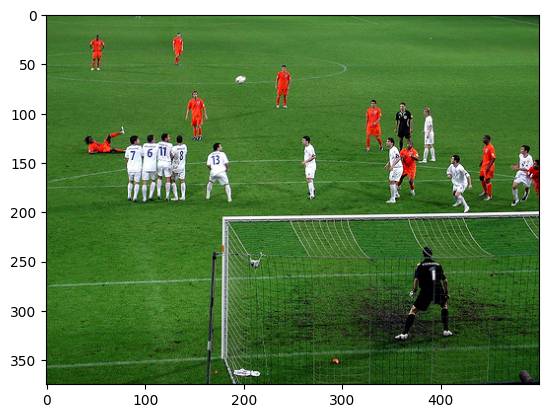

In [ ]:
## SAMPLE RUN
index = 9
test_image = ds.image[index]
plt.imshow(test_image.numpy())
print("caption:" , ds.caption_0[index].numpy())

## Process this test_image
processed_test_image = process_image(test_image).unsqueeze(0)
predicted_caption = predict(cnn_model, rnn_model, processed_test_image, device=device)
print("Predicted Caption:", predicted_caption)

# Trying out Transformers
Idea from : https://www.tensorflow.org/text/tutorials/image_captioning

Steps :  

1. Feature Extraction of Image (CNN)

2. Word Embedding : word + positional embedding

3. Decode Layer : Self attention, Cross Attention, Feed Forward Neural Network

4. Output : Post Processing of probability vector

## Feature Extraction

In [157]:
class CNN_feature_extraction(nn.Module):
  def __init__(self):
    """
    Initializes convolutional neural network
    """
    super(CNN_feature_extraction, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1).to(device) # (224,224,64)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1).to(device)# (224,224,128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1).to(device)# (224,224,256)

    self.relu = nn.ReLU()
    self.fc = nn.Linear(256 * 28 * 28, 512).to(device)
    self.fc2 = nn.Linear(512, 256).to(device)
    self.flatten = nn.Flatten()

    self.maxPool = nn.MaxPool2d(2, 2).to(device)

    self.batchNorm1 = nn.BatchNorm2d(64).to(device)
    self.batchNorm2 = nn.BatchNorm2d(128).to(device)
    self.batchNorm3 = nn.BatchNorm2d(256).to(device)

  def forward(self, x):
    """
    Forward pass of convolutional neural network
    Note: Output is already flattened
    """
    # for each layer, run convolutional layer, batch normalization layer,
    # then maxPool layer
    layer1 = self.maxPool(self.relu(self.batchNorm1(self.conv1(x)))) # batch_size, 64, 112, 112 (b, c , h, w )
    layer2 = self.maxPool(self.relu(self.batchNorm2(self.conv2(layer1)))) # batch_size, 128, 56, 56
    layer3 = self.maxPool(self.relu(self.batchNorm3(self.conv3(layer2)))) # batch_size, 256, 28, 28
    x1 = self.flatten(layer3)  # 1, 200704 = 256*28*28
    hidden = self.relu(self.fc(x1))
    x = self.fc2(hidden) # 1, 256
    return x

#### Tests for feature extractions

In [158]:
def test_feature_extraction():
    data_iter = iter(mini_eval_dataloader)
    batch = next(data_iter)
    images, labels = batch

    image = images[0].to(device)
    label = labels[0].to(device)  # Corresponding label (if available)

    feature_extractor = CNN_feature_extraction()
    features = feature_extractor(image.unsqueeze(0))
    assert features.size(0) == 1, "CNN dimension batch size incorrect."
    assert features.size(1) == 256, "CNN dimension incorrect."
    print("Test Passed!")

device = "cuda" if torch.cuda.is_available() else "cpu"
test_feature_extraction()

Test Passed!


## Embedding Layer
Embedding = Word + Positional Embedding.

In [159]:
## Hyperparameter
embed_dim = 256

In [160]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, max_length, dim):
        """
        Combines token and positional embeddings to produce sequence embeddings for Transformers.
        Input:
          vocab_size: size of vocab. Used for token embedding
          max_length: max length of caption. Used for positional embedding
          dim: Dimension of embedding vectors. Dimension of both token and positional Embedding
        """

        super().__init__()
        self.pos_embedding = nn.Embedding(num_embeddings=max_length, embedding_dim=dim).to(device)
        self.token_embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim, padding_idx=0).to(device) # ie padding_idx that = 0 will not be trained

    def forward(self, caption):
        """
          Input: Caption (batch, max_length = 20)
          Output: Embedding (batch, max_length, dim)
        """
        _, max_length = caption.shape

        token_embed = self.token_embedding(caption)

        # Create a positional array with length = caption length (20)
        positional_indices = torch.arange(max_length, device=caption.device).unsqueeze(0).to(device) # 1, 20
        position_embed = self.pos_embedding(positional_indices)

        return token_embed + position_embed

#### Test for embedding layer

In [161]:
def test_embedding_layer():
    data_iter = iter(mini_eval_dataloader)
    batch = next(data_iter)
    images, labels = batch

    image = images[0].to(device)
    label = labels[0].to(device)  # Corresponding label (if available)

    embedding = Embedding(vocab_size,caption_max_length,embed_dim)
    seq_embed = embedding(label)
    assert seq_embed.shape == (1,caption_max_length,embed_dim), "CNN dimension incorrect."
    print("Test Passed!")

device = "cuda" if torch.cuda.is_available() else "cpu"
test_embedding_layer()

Test Passed!


## Decoder
Contains self attention, cross attention, feed forward neural network

In [162]:
## Hyperparameter
num_heads = 1
dropout =  0.1

### Self Attention Layer

In [163]:
class SelfAttention(nn.Module):
    """
    Self-Attention mechanism for token embeddings. Capture dependencies between words.

    Inputs:
        embed_dim: Embedding dimension = embed_dim
        num_heads: The number of attention heads. Each head learns different aspects of the relationships between tokens.
        dropout: Dropout rate used to prevent overfitting
    """
    def __init__(self,  num_heads = 1, embed_dim = embed_dim, dropout=0.1):
        super(SelfAttention, self).__init__()

        print ("embed dim is ", embed_dim)

        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout).to(device)
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    def forward(self, x_token):
        """
        input shape : (batch, max_length, dim)
        output shape : (batch, max_length, dim)
        """
        attn_output, attn_output_weights = self.attention(query=x_token, key=x_token, value=x_token)
        x = x_token + attn_output  #Residual connection prevent vanishing grad
        return self.layernorm(x)

### Cross Attention Layer

In [164]:
class CrossAttention(nn.Module):
    """
    Cross Attention between caption and image.

    Input:
        Caption Embedding : (batch, seq_length, embed_dim)
        Image Feature Extraction : (batch, 256)
    """

    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super(CrossAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout).to(device)
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    def forward(self, caption, image):
        batch_size_c, seq_length, embed_dim = caption.shape
        batch_size_i, image_embed = image.shape
        assert batch_size_c == batch_size_i, "Batch Dimension of image and caption does not match"
        assert image_embed == 256, "Image Shape Incorrect"
        assert image_embed == embed_dim , "Image dimension does not match Token dimension"

        # create the same image for seq_length
        image_broadcasted = image.unsqueeze(1).repeat(1, seq_length, 1) # batch, seq_length, image_dim
        attn_output, attention_scores = self.mha(query=caption, key=image_broadcasted, value=image_broadcasted)
        caption = caption + attn_output  # Residual connection
        self.last_attention_scores = attention_scores
        return self.layernorm(caption)  #(batch, max_length, image_dim)

#### Tests for Cross Attention

### Feed Forward Neural Network

In [165]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(embed_dim, 2 * embed_dim).to(device),
            nn.ReLU(),
            nn.Linear(2 * embed_dim, embed_dim).to(device),
            nn.Dropout(dropout_rate)
        )
        self.layernorm = nn.LayerNorm(embed_dim).to(device)

    def forward(self, x):
        x = x + self.layer(x).to(device)
        return self.layernorm(x)


### Decoder Layer

In [166]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention = SelfAttention(num_heads, embed_dim, dropout)
        self.cross_attention = CrossAttention(embed_dim, num_heads, dropout)
        self.ffnn = FeedForward(embed_dim, dropout)

    def forward(self, inputs):
        image, caption = inputs
        caption_1 = self.self_attention(caption)
        output_seq = self.cross_attention(caption_1, image)
        out_seq = self.ffnn(output_seq)

        self.last_attention_scores = self.cross_attention.last_attention_scores

        return out_seq # batch, seq_length, embed_dim

## Combine + Data PostProcessing

1. Problem: Some tokens occur much more frequently than others in the dataset.
Without adjustment, the model may develop a bias toward predicting these frequent tokens, regardless of context.
Incorporate token frequency information in the logits using the bias term.
For instance, less frequent tokens are given a higher weight, encouraging the model to predict them when appropriate.

2. Problem: Some tokens, like [UNK] or [START], are placeholders or special tokens not intended for prediction.
Solution:
Add a large negative bias (-1e9) to these tokens' logits to make their probabilities effectively zero after softmax.
This guarantees they are not predicted during decoding.

In [113]:
import collections
from tqdm import tqdm

In [114]:
class PostProcessing(nn.Module):
    def __init__(self, embed_dim, tokenizer, banned_tokens=('[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in')):

        super(PostProcessing, self).__init__()
        self.vocab_size = tokenizer.vocab_size
        self.tokenizer = tokenizer
        self.fc = nn.Linear(embed_dim, out_features=tokenizer.vocab_size).to(device) ## Goal is to map to vocab size # batch, seq_length, vocab_size
        self.banned_tokens = banned_tokens

        self.bias = None

    def adapt(self, dataset):
        """
            vocab_dict: a dictionary to map vocab word to assigned index (from 0 to vocab_size)
            counts : a dictionary holding frequency of each word(token), key: id value :freq
        """
        counts = collections.Counter()
        vocab_dict = {name: id for id, name in enumerate(self.tokenizer.vocab)} # map name to id


        for tokens in tqdm(dataset):
            counts.update(tokens.numpy().flatten())  # Update freq for token in the sentence

        # Turn Frequency into an array of all vocabulary
        # fill vocab array with freq
        # array indices = token_id
        counts_arr = np.zeros(shape=(self.vocab_size,))
        indices = np.array(list(counts.keys()), dtype=np.int32)
        counts_arr[indices] = list(counts.values())


        for token in self.banned_tokens:
            id = vocab_dict[token]
            counts_arr[id] = 0

        total = counts_arr.sum()
        p = counts_arr / total
        p[counts_arr == 0] = 1.0  # Prevent log(0)
        log_p = np.log(p)  # log(1) == 0

        entropy = -(log_p * p).sum()

        # print(f"\nUniform entropy: {np.log(self.tokenizer.vocab_size):0.2f}")
        # print(f"Marginal entropy: {entropy:0.2f}")

        self.bias = torch.tensor(log_p, dtype=torch.float32)
        self.bias[counts_arr == 0] = -1e9  # Set large negative values for banned tokens

    def forward(self, input):
        input = input.float()
        x = self.fc(input)
        x = x + self.bias.to(x.device)  # Ensure bias is on the same device as the input
        return x

## Image Captioner : Put all together

In [115]:
banned_tokens=('[UNK]', '[PAD]', '[SEP]', '[CLS]', '[MASK]', 'the', 'a', 'in')

class ImageCaption(nn.Module):
    def __init__(self, tokenizer, vocab_size, num_layers=1, embed_dim=256, max_length=20, num_heads=2, dropout=0.1):
        super(ImageCaption, self).__init__()

        self.feature_extractor_model = CNN_feature_extraction()
        self.embedding = Embedding(vocab_size , max_length, embed_dim)
        self.decoder_layer = DecoderLayer(embed_dim)
        self.post_processing_model = PostProcessing(256, tokenizer, banned_tokens = banned_tokens)

        self.tokenizer = tokenizer

        # self.decoder_layers = nn.ModuleList([
        #     DecoderLayer(embed_dim)
        #     for _ in range(num_layers)
        # ])


    def forward(self, inputs):
        image, caption = inputs

        # Step 1: Extract Features
        extracted_image = self.feature_extractor_model(image)

        # Step 2: Embed the tokens
        tokens = self.embedding(caption)

        # Step 3: Decode
        token_output = self.decoder_layer((extracted_image, tokens))

        output = self.post_processing(token_output)

        return output

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image_caption_model = ImageCaption(tokenizer, vocab_size)

embed dim is  256


## Train

In [133]:
def banned_tokens_to_ids(tokenizer, banned_tokens):
  res = []
  vocab_dict = {name: id for id, name in enumerate(tokenizer.vocab)}
  for token in banned_tokens:
    id = vocab_dict[token]
    res.append(id)
  print (res)
  return res

In [135]:
banned_token_ids = banned_tokens_to_ids(tokenizer, banned_tokens)

[100, 0, 102, 101, 103, 1996, 1037, 1999]


In [150]:
def train_model(cnn_feature_extraction, embedder, decoder, post_processor, banned_token_ids, data_loader, ratio = 0.5, device="cpu"):
  print (device)
  cnn_feature_extraction.train()
  embedder.train()
  decoder.train()
  post_processor.train()

  # original_dataset = data_loader.dataset.dataset

  # indices = data_loader.dataset.indices
  # subset_data = [original_dataset.captions[i] for i in indices]
  # print (subset_data)

  for epoch in range(num_epochs):

    total_loss = 0.0

    count = 0
    for image, c in data_loader:
      captions_list = c[0][0].tolist()  # Convert tensor to list
      decoded_captions = [tokenizer.decode(cap) for cap in captions_list]
      # print (decoded_captions)

      if count == 0:
        all_captions = torch.empty(0, dtype=c.dtype, device=c.device)
      count += 1
      all_captions = torch.cat((all_captions, c.flatten()))

    post_processor.adapt(all_captions)

    for images, captions in data_loader:

      # index = data_loader.dataset.indices[count]

      # test_image = ds.image[index]
      # plt.imshow(test_image.numpy())

      # display(plt.gcf())

      count += 1

      images = images.to(device)

      # images = images.cpu()
      captions = captions.to(device).long()
      # captions = captions.cpu()

      batch_size = len(images) # for each item images set how many are there

      optimizer_cnn.zero_grad()
      optimizer_embedder.zero_grad()
      optimizer_decoder.zero_grad()
      optimizer_post_processor.zero_grad()

      features = cnn_feature_extraction(images)  # shape: 1 x 256
      captions = captions.squeeze(1)

      # list to store full outputs
      outputs = []    # shape: length (grows) * 1 * vocab_size

      # store specific word tokens that have been chosen
      token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)  # shape: batch * 1

      seq_length = captions.size(1)

      predicted_words = set()

      for t in range(1, seq_length):

        # run embedder on current tokens
        post_embed = embedder(token)  # shape: batch * token_length (t) * embed_dim

        # run decoder layer
        output = decoder((features, post_embed))  # shape: batch * token_length * embed_dim

        # select the last word
        output_new = output[:, -1, :]    # shape: batch * 1 * embed_dim

        # run through post processing to get vocab size dimension
        after_post_process = post_processor(output_new)    # shape: batch * vocab_size

        for word in predicted_words:
          after_post_process[:, word] -= 1e9

        outputs.append(after_post_process)

        real = True

        # teacher forcing
        ratio = 0.5 - 0.05 * epoch
        if random.random() < ratio:
          next_word = captions[:, t]
          real = False

        else:
          next_word = torch.argmax(after_post_process, dim=1)   # gets most likely word

        if real:
          print (untokenize(next_word[0]))

        predicted_words.add(next_word)

        token = torch.cat((token, next_word.unsqueeze(0)), dim=1)   # shape: batch * token_length

        if next_word[0] == tokenizer.sep_token_id:   # if ending word: break
          break

      outputs = torch.stack(outputs, dim=1)  # shape: batch * (seq_length - 1) * vocab_size
      outputs = outputs.reshape(-1, outputs.size(2))   # shape: (seq_length - 1) * vocab_size (or shorter in first dim if early termination)


      caption_original = captions[:, 1:]
      caption_original = caption_original.contiguous().view(-1) # shape: (seq-length - 1)

      # computes loss
      length = outputs.shape[0]
      if length < caption_original.shape[0]:
        caption_original = caption_original[:length]


      mask_banned = torch.isin(caption_original, torch.tensor(banned_token_ids).to(device))
      mask_predicted = torch.isin(caption_original, torch.tensor(list(predicted_words)).to(device))
      union_mask = mask_banned | mask_predicted

      mask = ~union_mask

      outputs = outputs[mask]
      caption_original = caption_original[mask]

      loss = criterion(outputs, caption_original)

      loss.backward()
      optimizer_cnn.step()
      optimizer_embedder.step()
      optimizer_decoder.step()
      optimizer_post_processor.step()
      total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# remaining things to figure out:
# 1. Make sure the loop is actually right (bug-free != correct)
# 2. The bias thing in post-processing wasn't working; I just commented it out but we'll try again
# 3. If the ending token is generated before 20, I just cut the original caption
# short for computing loss. Is this the best way?
# 4. How does this actually perfrom? Training loss seems high, want to see eval and predict...
# 5. Running on CPU, want to get GPU working

In [151]:
torch.autograd.set_detect_anomaly(True)

cnn_feature_extraction = image_caption_model.feature_extractor_model
embedder = image_caption_model.embedding
decoder = image_caption_model.decoder_layer
post_processor = image_caption_model.post_processing_model

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_feature_extraction.parameters(), lr=0.001)
optimizer_embedder = torch.optim.Adam(embedder.parameters(), lr=0.001)
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr=0.001)
optimizer_post_processor = torch.optim.Adam(post_processor.parameters(), lr=0.001)

num_epochs = 10

print (mini_train_dataloader)
train_model(cnn_feature_extraction, embedder, decoder, post_processor, banned_token_ids, mini_train_dataloader, device=device)

cuda


100%|██████████| 2000/2000 [00:00<00:00, 67030.04it/s]


.
and
with
man
,
on
young
of
with
dog
on
large
running
man
is
.
and
wearing
,
blue
are
of
dog
running
man
.
large
on
dressed
of
running
man
blue
,
dog
brown
on
large
is
man
of
running
brown
with
,
blue
woman
dog
.
of
brown
with
on
woman
blue
and
of
brown
with
woman
.
of
brown
woman
two
blue
with
on
children
is
hair
.
of
woman
brown
two
blue
children
with
is
which
.
woman
of
two
brown
which
blue
children
with
.
people
of
woman
two
brown
which
children
blue
shirt
is
running
outside
.
of
dog
two
woman
which
brown
group
shirt
and
blue
outside
.
group
woman
man
two
of
shirt
which
children
and
outside
.
running
group
and
shirt
which
two
of
.
group
of
and
groom
shirt
which
man
two
children
.
group
and
shirt
children
of
,
two
while
which
.
group
and
while
,
shirt
children
dog
which
of
two
brown
.
group
and
while
,
white
dog
of
children
two
.
group
and
people
while
white
shirt
dog
.
group
and
while
,
of
white
dog
.
group
and
while
,
white
.
group
and
while
,
black
with
white
wearing
dog
.
group

100%|██████████| 2000/2000 [00:00<00:00, 63021.54it/s]


.
shallow
and
walks
brown
to
with
up
##s
.
and
,
##s
up
with
to
including
man
on
is
##board
brown
biker
walks
.
and
man
with
,
woman
##s
them
to
walks
.
with
man
,
to
##s
blue
on
##board
group
woman
.
black
with
wearing
,
and
to
woman
on
.
with
man
wearing
,
is
woman
to
on
water
group
##s
.
with
people
,
is
man
woman
wearing
water
group
two
amid
.
with
wearing
water
,
dressed
woman
man
to
and
striped
group
blue
.
with
water
wearing
man
woman
two
dressed
group
,
to
striped
.
wearing
with
,
water
group
two
dressed
is
woman
striped
man
there
blue
.
water
with
wearing
,
two
woman
striped
dressed
group
carrying
there
on
.
people
with
water
two
wearing
dressed
striped
woman
and
.
with
water
two
woman
wearing
carrying
blue
.
water
with
wearing
shirt
two
,
carrying
there
.
with
shirt
water
wearing
,
woman
carrying
two
of
there
dressed
.
with
water
shirt
wearing
,
carrying
woman
striped
two
there
.
shirt
water
,
two
is
wearing
carrying
black
.
shirt
with
to
water
,
of
man
carrying
two
.
while
,

100%|██████████| 2000/2000 [00:00<00:00, 87496.17it/s]


and
on
paint
computer
jersey
with
nissan
banda
them
and
jersey
computer
with
paint
of
behind
on
is
shore
and
with
on
behind
shore
paint
,
jersey
big
girl
computer
with
and
is
behind
on
another
,
paint
of
jersey
with
and
on
is
.
another
,
girl
big
workers
of
behind
paint
dog
brown
another
with
and
on
.
of
brown
,
is
with
and
on
of
another
brown
with
and
on
of
another
girl
is
brown
.
,
people
two
with
on
is
another
and
brown
.
of
people
man
wearing
with
on
and
two
with
is
and
on
two
people
.
brown
dog
of
with
and
is
on
people
brown
two
.
,
there
of
water
black
another
with
is
grassy
of
people
two
and
on
metal
there
.
brown
with
is
two
on
people
.
and
with
people
is
on
two
.
of
and
there
,
brown
blue
running
with
is
people
two
.
on
and
brown
of
there
,
with
people
is
two
.
on
,
and
of
there
with
people
is
.
two
on
,
there
of
running
with
is
people
,
.
on
two
of
and
man
there
black
running
is
girl
with
people
two
.
on
and
,
of
man
city
is
with
people
.
two
,
on
there
man
of
and
city
brown


100%|██████████| 2000/2000 [00:00<00:00, 85431.54it/s]


skate
man
runs
blue
young
man
and
,
is
skate
of
blue
girl
.
on
runs
jumping
dog
standing
is
blue
man
skate
,
on
runs
girl
.
of
blue
,
man
and
is
skate
dog
another
runs
of
girl
blue
man
is
wearing
with
and
on
of
skate
,
man
blue
is
with
and
brown
of
young
,
jumping
grassy
.
skate
on
girl
standing
runs
is
blue
with
man
another
and
brown
skate
of
.
,
on
ground
dog
blue
is
with
brown
man
and
skate
young
another
of
.
on
,
dog
jumping
blue
with
is
man
brown
and
another
,
of
grassy
on
dog
jumping
young
blue
with
brown
is
man
and
wearing
blue
with
brown
is
man
and
another
young
of
,
.
with
blue
is
brown
man
and
of
another
.
is
blue
with
man
another
and
of
.
grass
running
on
,
shirt
blue
young
with
brown
is
of
man
and
.
another
with
blue
brown
is
man
of
on
another
and
.
running
blue
with
is
brown
of
man
another
dog
and
running
,
white
blue
with
is
brown
of
running
man
dog
another
with
blue
is
brown
man
of
dog
running
.
shirt
white
an
,
blue
with
is
brown
man
of
shirt
and
.
running
dog
wearing
w

100%|██████████| 2000/2000 [00:00<00:00, 70665.31it/s]


standing
man
small
.
while
on
and
with
water
,
of
along
jeans
eating
standing
man
small
while
on
.
along
of
,
with
and
to
standing
man
small
on
is
,
while
.
woman
of
along
orange
jeans
man
standing
is
and
small
on
.
while
of
his
sits
orange
with
jeans
dog
standing
man
small
on
and
,
.
is
while
of
to
his
man
standing
on
small
is
and
while
.
black
with
his
of
jeans
orange
to
,
standing
man
on
small
while
and
is
.
black
his
of
with
,
orange
has
man
standing
small
is
on
while
.
and
are
of
with
man
standing
on
small
and
is
of
while
.
,
his
an
orange
woman
man
standing
on
is
small
and
.
his
while
,
brown
dog
to
woman
black
##s
orange
man
standing
on
small
.
is
while
brown
of
,
with
black
man
small
on
standing
is
and
,
of
.
man
standing
is
on
small
and
.
while
,
two
large
of
shirt
his
man
standing
is
on
and
small
of
.
,
shirt
man
standing
shirt
on
and
is
small
,
.
dog
brown
of
his
while
man
is
standing
wearing
on
and
.
while
of
small
,
woman
man
standing
on
is
and
dog
shirt
.
while
of
,
brown

100%|██████████| 2000/2000 [00:00<00:00, 62310.92it/s]


,
man
standing
small
with
two
.
grass
,
##board
man
small
standing
.
his
with
grass
on
and
two
dog
while
dress
,
man
is
small
his
standing
on
with
dog
grass
are
,
man
small
standing
on
.
is
his
supervisor
water
grass
with
them
dog
landscape
man
,
is
small
grass
his
.
standing
on
,
man
is
his
standing
supervisor
small
on
with
and
them
water
.
dog
while
an
,
man
is
on
two
standing
small
and
his
with
,
man
and
with
is
standing
of
on
two
small
wearing
dog
water
grass
.
,
man
on
two
is
standing
small
and
of
supervisor
.
them
water
with
while
people
dog
man
wearing
,
and
is
standing
people
two
small
.
with
on
dog
grass
water
,
man
two
and
is
wearing
face
dog
people
grass
,
man
and
.
two
is
wearing
with
standing
grass
them
on
his
small
of
,
man
wearing
and
two
is
an
grass
.
shirt
people
with
on
,
man
two
an
and
grass
people
is
wearing
his
on
.
,
man
is
two
and
an
supervisor
people
with
.
wearing
,
man
two
grass
and
with
wearing
is
.
people
an
blue
shirt
of
young
,
man
and
two
an
shirt
.
his
b

100%|██████████| 2000/2000 [00:00<00:00, 112193.66it/s]


small
,
is
young
standing
shirt
to
are
man
while
.
and
of
on
dog
with
wearing
small
,
and
is
to
are
standing
young
man
with
while
dog
of
.
on
grass
jeans
small
man
,
is
are
standing
to
and
young
of
.
grass
them
on
one
small
is
,
man
are
to
standing
on
young
of
.
ground
black
dog
shirt
blue
small
,
is
standing
to
are
girl
of
young
on
man
with
and
shirt
gear
small
,
is
young
to
of
standing
are
.
shirt
while
man
girl
on
carrying
them
small
,
is
to
are
standing
young
and
on
of
man
girl
.
with
,
small
is
to
standing
young
are
shirt
girl
man
dog
brown
with
and
of
grass
small
is
to
,
are
man
young
.
standing
girl
of
shirt
dog
on
blue
small
is
,
to
are
girl
young
standing
carrying
blue
man
black
shirt
of
dog
with
two
small
,
is
are
to
with
girl
young
standing
of
dog
man
ground
blue
and
.
,
small
to
young
is
are
girl
of
standing
boy
shirt
.
carrying
,
small
is
to
standing
shirt
.
girl
are
people
young
carrying
of
with
small
are
,
to
young
is
standing
girl
of
people
shirt
carrying
.
brown
man
wh

100%|██████████| 2000/2000 [00:00<00:00, 104810.44it/s]


with
small
,
is
of
and
man
blue
.
while
on
young
girl
water
white
to
black
grass
with
and
small
is
,
water
of
man
white
.
wearing
black
while
blue
people
girl
is
children
with
of
small
water
young
,
.
man
white
standing
while
girl
to
with
small
,
is
man
of
while
wearing
.
people
blue
black
water
on
and
standing
with
small
is
,
man
blue
black
of
standing
water
people
wearing
while
girl
young
and
has
an
with
man
of
people
and
small
,
blue
is
has
water
girl
black
young
wearing
.
with
small
of
,
is
blue
man
white
wearing
dog
people
and
standing
water
with
is
small
man
wearing
of
,
people
blue
black
young
water
standing
and
on
white
.
while
with
people
of
is
man
black
wearing
,
blue
small
and
water
.
standing
on
dog
young
with
man
is
and
,
small
black
wearing
blue
people
water
of
standing
on
.
grass
dog
with
and
blue
is
man
wearing
small
,
.
of
people
grass
black
water
standing
shirt
brown
dog
with
man
blue
,
and
small
wearing
is
on
people
black
of
grass
water
black
with
,
is
blue
man
weari

100%|██████████| 2000/2000 [00:00<00:00, 114503.05it/s]


are
is
front
with
and
to
,
white
jersey
dog
.
man
of
watching
them
small
while
are
wearing
to
is
dog
front
.
,
an
and
with
children
them
of
standing
himself
are
to
front
,
is
and
.
with
man
small
them
standing
dog
blue
of
lecture
white
are
to
front
.
with
and
them
standing
dog
brown
on
white
small
man
,
shirt
girl
black
are
is
to
front
and
with
girl
man
white
them
small
standing
dog
eating
brown
shirt
,
are
front
is
and
dog
to
brown
small
white
girl
with
large
them
black
.
shirt
man
,
are
front
is
brown
to
with
and
man
while
them
black
standing
girl
.
white
of
on
tricks
,
are
to
of
front
is
girl
with
and
.
brown
man
them
on
dog
white
are
to
front
is
dog
and
man
brown
on
girl
small
with
standing
sweater
shirt
,
black
are
standing
man
is
and
front
dog
brown
to
with
girl
on
shirt
while
them
white
blue
are
woman
brown
front
is
dog
and
to
with
girl
shirt
standing
people
.
on
,
man
them
are
front
brown
is
and
girl
standing
dog
shirt
to
.
man
on
black
blue
while
them
with
are
front
to
and
is


100%|██████████| 2000/2000 [00:00<00:00, 68556.22it/s]


small
are
.
man
black
his
of
,
and
is
with
to
on
them
girl
brown
dog
jacket
shirt
small
are
man
of
black
.
is
girl
,
on
and
young
grass
them
his
to
brown
people
small
are
black
.
is
on
man
while
of
,
with
girl
them
to
blue
young
small
are
man
.
,
of
and
black
is
standing
brown
to
his
people
with
blue
small
are
black
man
is
of
on
and
,
##lit
.
girl
standing
blue
people
them
one
his
with
small
are
man
is
of
and
standing
.
people
,
black
on
with
his
young
them
blue
small
are
of
man
person
.
,
and
is
people
##lit
blue
black
on
girl
to
standing
has
them
small
children
and
are
man
is
of
standing
,
black
.
people
them
his
to
whilst
girl
blue
with
small
are
man
black
.
and
people
is
standing
of
on
,
blue
his
them
girl
##lit
large
small
and
are
standing
man
is
of
blue
.
girl
on
top
,
person
people
one
black
brown
with
small
are
man
and
##lit
blue
on
standing
.
his
is
grassy
,
of
black
pink
top
large
with
small
man
are
and
,
blue
.
is
standing
people
something
brown
them
of
carrying
black
while


**Predict**

In [152]:
def predict(cnn_feature_extraction, embedder, decoder, post_processor, image, device='cpu'):
  cnn_feature_extraction.eval()
  embedder.eval()
  decoder.eval()
  post_processor.eval()
  image = image.to(device)

  with torch.no_grad():
      features = cnn_feature_extraction(image)


  batch_size = 1
  max_length = 20

  start_token = torch.full((batch_size, 1), tokenizer.cls_token_id).to(device)

  count = 0
  for image, c in mini_train_dataloader:
    captions_list = c[0][0].tolist()  # Convert tensor to list
    decoded_captions = [tokenizer.decode(cap) for cap in captions_list]
    # print (decoded_captions)

    if count == 0:
      all_captions = torch.empty(0, dtype=c.dtype, device=c.device)
    count += 1
    all_captions = torch.cat((all_captions, c.flatten()))

  post_processor.adapt(all_captions)

  # hidden = rnn.init_hidden(batch_size)
  predictions = []
  input = start_token

  predicted_words = set()

  for _ in range(max_length):
      with torch.no_grad():
          post_embed = embedder(input)

          output = decoder((features, post_embed))

          output_new = output[:, -1, :]

          after_post_process = post_processor(output_new)    # shape: batch * embed_dim

          for word in predicted_words:
              after_post_process[:, word] -= 1e9

          # outputs.append(after_post_process)

          next_word = torch.argmax(after_post_process, dim=1)   # gets most likely word

          predicted_words.add(next_word)

          last_predicted_word = next_word

          input = torch.cat((input, next_word.unsqueeze(0)), dim=1)   # shape: batch * token_length

          predictions.append(next_word.item())

          # if predict a </e> end token, Exit
          if next_word[0] == tokenizer.sep_token_id:
              break

  predictions = untokenize(predictions)
  return predictions

caption: ['Crowds of people are walking are multicolored tents and flags that are put up outside in a cement lot as a big city looms in the distance .']


100%|██████████| 2000/2000 [00:00<00:00, 72349.89it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['Two women in a light blue and a dark blue jacket walking in a crosswalk and a fake giant rat is on the sidewalk behind them .']


100%|██████████| 2000/2000 [00:00<00:00, 81642.54it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A security officer with a tiny face and big glasses leans on a metal gate looking into the camera .']


100%|██████████| 2000/2000 [00:00<00:00, 39261.30it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A man with a white shirt with his mouth open wide and turning buttons .']


100%|██████████| 2000/2000 [00:00<00:00, 119336.05it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A man enjoys a peaceful solitary moment while camping .']


100%|██████████| 2000/2000 [00:00<00:00, 120616.09it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A young Indian male is hitting a red ball with a bat next to a brown chair .']


100%|██████████| 2000/2000 [00:00<00:00, 123392.73it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A young girl and young boy are playing with pails of water with the ocean in the background .']


100%|██████████| 2000/2000 [00:00<00:00, 120629.97it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A man with brown hair is all wet wearing a black shirt that someone is helping him with .']


100%|██████████| 2000/2000 [00:00<00:00, 113066.21it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['Man breakdancing while trying to push himself off the ground , while his legs are in the air and hands and head on the floor .']


100%|██████████| 2000/2000 [00:00<00:00, 116421.13it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['Men dressed in red and men dressed in white are playing a game of soccer .']


100%|██████████| 2000/2000 [00:00<00:00, 125828.49it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A man and a little boy in blue life jackets are rowing a yellow canoe .']


100%|██████████| 2000/2000 [00:00<00:00, 119107.30it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['Senior citizen with blue shirt and blue pants standing outdoors with hands behind his back .']


100%|██████████| 2000/2000 [00:00<00:00, 117660.54it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['a large house with three stories and 3 matching balconies , with one person standing on each balcony overlooking onlookers .']


100%|██████████| 2000/2000 [00:00<00:00, 106121.78it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['An elderly American male looking before he steps outside of a subway train .']


100%|██████████| 2000/2000 [00:00<00:00, 73895.42it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A woman in a skirt and green t-shirt has her arm draped over the shoulder of a younger woman in a white skirt and orange t-shirt .']


100%|██████████| 2000/2000 [00:00<00:00, 80672.10it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['A man and woman wearing sunglasses and white t-shirts smile for the camera .']


100%|██████████| 2000/2000 [00:00<00:00, 112721.32it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['This stone sculptor gently shaded seems to decorate a garden but here a young boy dressed in a US flag decorated t-shirt enjoys climbing on it .']


100%|██████████| 2000/2000 [00:00<00:00, 118509.95it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['Two football players leap into the air as a player on the opposing team moves toward them .']


100%|██████████| 2000/2000 [00:00<00:00, 103510.67it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['There are two men and a woman in church , the woman is in the back and the men are next to a piano .']


100%|██████████| 2000/2000 [00:00<00:00, 109912.19it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them

caption: ['Five people are laying on beach chairs while one man is raising his hand to the camera .']


100%|██████████| 2000/2000 [00:00<00:00, 118805.35it/s]


Predicted Caption: small his are. and dog standing man with, on black to blue young while people girl wearing them



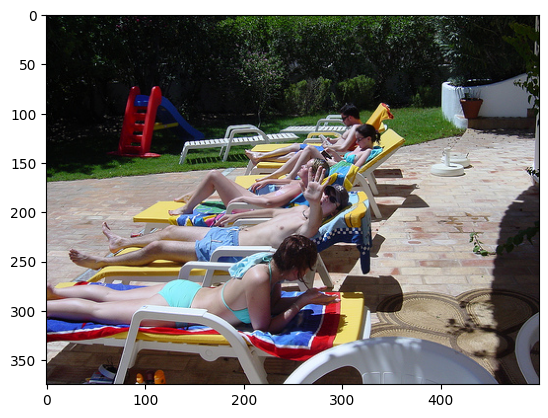

In [154]:
## SAMPLE RUN
for index in range(0, 20):
  test_image = ds.image[index]
  plt.imshow(test_image.numpy())
  print("caption:" , ds.caption_0[index].numpy())

  ## Process this test_image
  processed_test_image = process_image(test_image).unsqueeze(0)
  predicted_caption = predict(cnn_feature_extraction, embedder, decoder, post_processor, processed_test_image, device=device)
  print("Predicted Caption:", predicted_caption)
  print ()